# Modularity optimization on Malaria data

In this notebook we aim to apply modularity optimization on [Dataset name]

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(1)

## Data:

We use a network of recombinant antigen genes from the human malaria parasite P. falciparum. Nodes are var genes, and two genes are connected if they share a substring (on a highly variable region (HVR) in the DBLa domain of the var protein) whose length is statistically significant.

In this framework, modularity optimization can provide meaningful insights into the biology and pathogenicity of P. falciparum.. Indeed, communities identified through modularity optimization may correspond to functionally related or co-expressed var genes that, therefore, may have similar biological roles or may be involved in similar immune evasion strategies. Moreover, a more extensive analysis of malaria data can eventually be relevant for vaccines and drugs design.

## Modularity optimization and Resolution limit:

Taking everything into account, we perform community optimization. The chosen algorithm is the Louvain Community Detection Algorithm.

In [7]:
G = nx.read_edgelist("data/HVR_1.txt", delimiter=',', comments = '%', nodetype=int)

# other networks "data/HVR_5.txt"

if nx.is_connected(G):  
    print('The network is connected.')
else:
    print('The network is not connected.')

print(f'There are a total of {len(G.nodes)} nodes and {len(G.edges)} edges.\n')

The network is connected.
There are a total of 307 nodes and 2812 edges.



In [8]:
communities = nx.community.louvain_communities(G, seed=1)

modularity_value = nx.community.modularity(G, communities)
print(f'Modularity: ', modularity_value)

Modularity:  0.6358202577249705


In [9]:
def plot_communities(G, communities, fig, ax, prefix = "", verbose = True):

    fig, ax = fig, ax
    
    # define node positions
    pos = nx.spring_layout(G, seed = 1)

    # Create a colormap to generate distinct colors
    cmap = plt.get_cmap('gist_rainbow')

    # Draw nodes with dynamically generated community-based colors
    for i, community in enumerate(communities):
        print(f"{prefix}community {i+1}")
        color = cmap((i) / (len(communities)))  # Dynamically generate colors based on the number of communities
        print(list(community))
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=[color], label=f'{prefix}community {i + 1}', node_size=15)

    # draw the network
    #nx.draw_networkx_nodes(G, pos, node_color=colors, cmap = plt.get_cmap('tab20'), node_size = 10)
    nx.draw_networkx_edges(G, pos, alpha = 0.5)
    nx.draw_networkx_labels(G, pos, verticalalignment='bottom')
    #plt.title("Communities")

    #labels = {i: f'Commuity {i}' for i in range(len(communities))}
    cax = plt.axes([0.85, 0.15, 0.03, 0.7])  # Adjust the position and size as needed

    sm = plt.cm.ScalarMappable(cmap = plt.get_cmap('gist_rainbow'), norm = plt.Normalize(vmin = 0, vmax = len(communities)))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax = cax)
    # Set colorbar labels
    cbar.set_ticks([i for i in range(len(communities))])
    cbar.set_ticklabels([f'{prefix}community {i+1}' for i in range(len(communities))])
    # Adjust the font size
    cbar.ax.tick_params(labelsize=8)

    # Remove the box around the plot
    ax.set_frame_on(False)



community 1
[32, 34, 35, 36, 9, 52, 53, 54, 55, 56, 30, 31]
community 2
[1, 16, 18, 19, 21, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 58]
community 3
[2, 3, 4, 5, 6, 7, 8, 10, 11, 268, 269, 12, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29, 33, 51, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 78, 94, 95, 100, 101, 106, 111, 112, 250, 251, 252, 253, 254]
community 4
[256, 260, 261, 71, 247, 72]
community 5
[257, 258, 259, 262, 263, 264, 265, 266, 267, 270, 273, 274, 275, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 294, 306, 69, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 93, 97, 98, 99, 102, 103, 104, 105, 107, 108, 109, 110, 113, 114, 118, 119, 120, 121, 123, 124, 170, 171, 172, 173, 174, 175, 176, 177, 178, 185, 211, 212, 213, 214, 215, 219, 249, 255]
community 6
[70, 73, 74, 75, 76, 89, 115, 116, 117, 122, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,

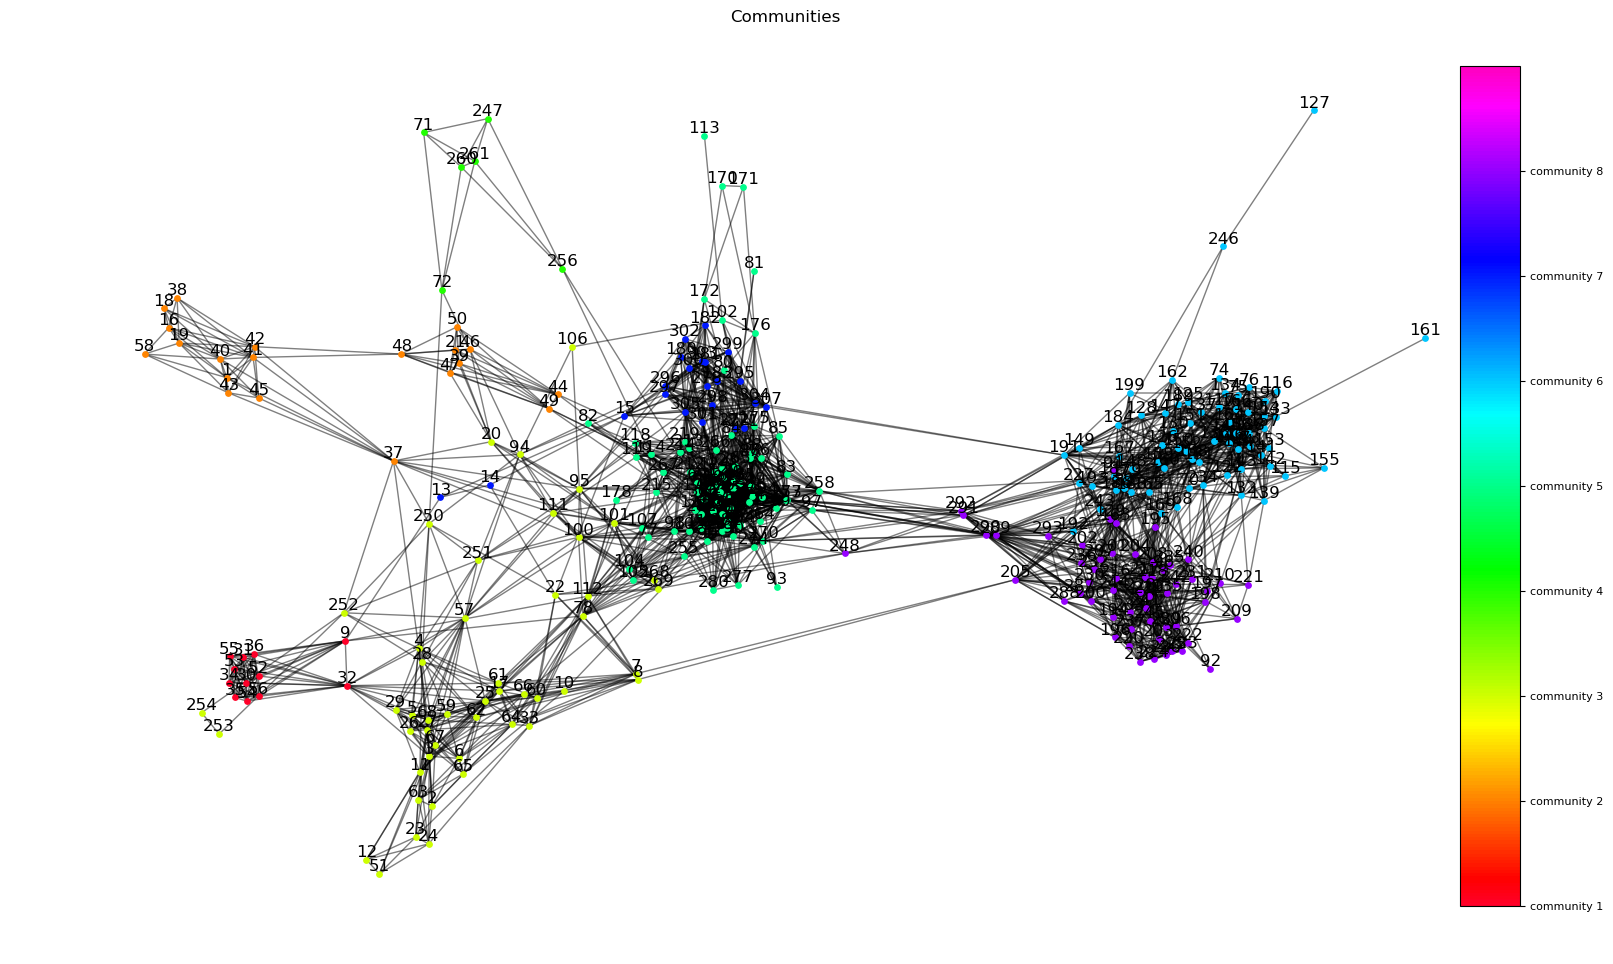

In [10]:
fig, ax = plt.subplots(figsize= (20,12))
ax.set_title("Communities")
plot_communities(G, communities, fig, ax)

plt.savefig('malaria_antigen_communities.png')

plt.show()

Once the Louvain Algorithm returned the optimal partition of the network into communities, we can tackle the issue of resolution limit. We constrain our analysis on each of the module and develop an algorithm whose aim is to detect whether they are coherent groups or ensemble of smaller communities.

In [13]:
def louvain_on_communities(G, communities):
    # for each community we create a subgraph on which we apply again the 
    # Louvain algorithm
    # initialize the environment for the subplots
    #subplots_per_row = 3
    #n_rows = (len(communities) + subplots_per_row -1) // 3
    #fig, axes = plt.subplots(n_rows, subplots_per_row, figsize = (20, 5 * n_rows))

    for i, community in enumerate(communities):
        fig, ax = plt.subplots(figsize = (9, 6))
        # apply the Louvain algorithm on a single community
        # note that in doing so we are discarding the edges that connect the 
        subgraph = G.subgraph([node for node in community])
        subcommunities = nx.community.louvain_communities(subgraph, seed=1)

        modularity_sub = nx.community.modularity(subgraph, subcommunities)

        print(f'Constraining on community {i+1}, the modularity is {modularity_sub}.')

        print(f'It has {len(subgraph.nodes)} nodes and {len(subgraph.edges)} edges.')

        ax.set_title(f"Subcommunity {i+1}")
        plot_communities(subgraph, subcommunities, fig, ax, prefix = "sub")

        plt.savefig(f'{i+1}_subcommunity.png')
        plt.show()


Constraining on community 1, the modularity is 0.0.
It has 12 nodes and 66 edges.
subcommunity 1
[32, 34, 35, 36, 9, 52, 53, 54, 55, 56, 30, 31]


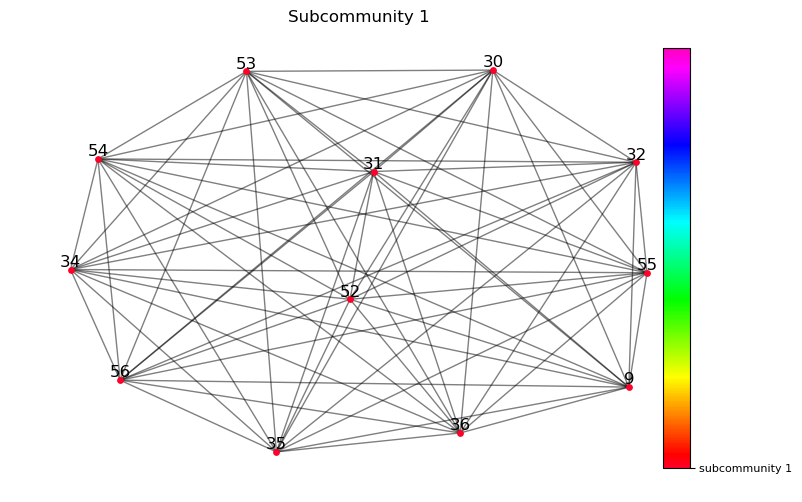

Constraining on community 2, the modularity is 0.44358239163433966.
It has 20 nodes and 77 edges.
subcommunity 1
[39, 44, 46, 47, 48, 49, 50, 21]
subcommunity 2
[1, 37, 38, 40, 41, 42, 43, 45, 16, 18, 19, 58]


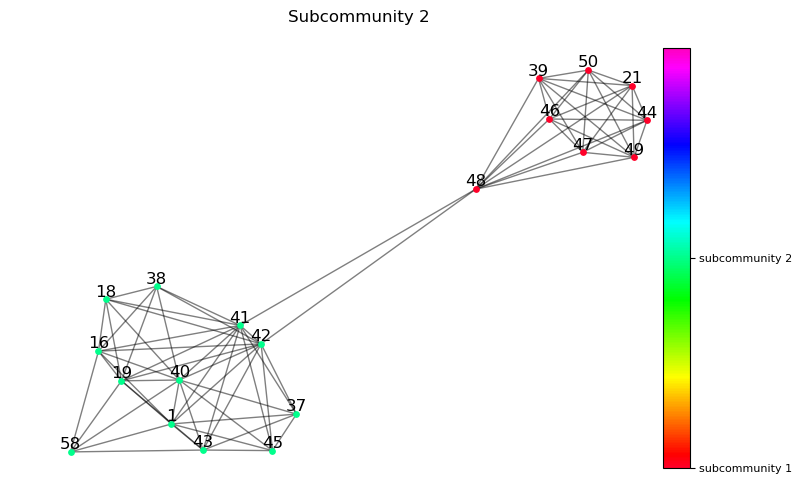

Constraining on community 3, the modularity is 0.3848270196540392.
It has 48 nodes and 254 edges.
subcommunity 1
[64, 33, 7, 8, 78, 112, 17, 22, 60, 61, 62]
subcommunity 2
[51, 23, 24, 11, 12]
subcommunity 3
[65, 66, 67, 68, 5, 2, 3, 6, 59, 10, 25, 26, 27, 29, 63]
subcommunity 4
[4, 268, 269, 20, 28, 94, 95, 100, 101, 106, 111, 57, 250, 251, 252, 253, 254]


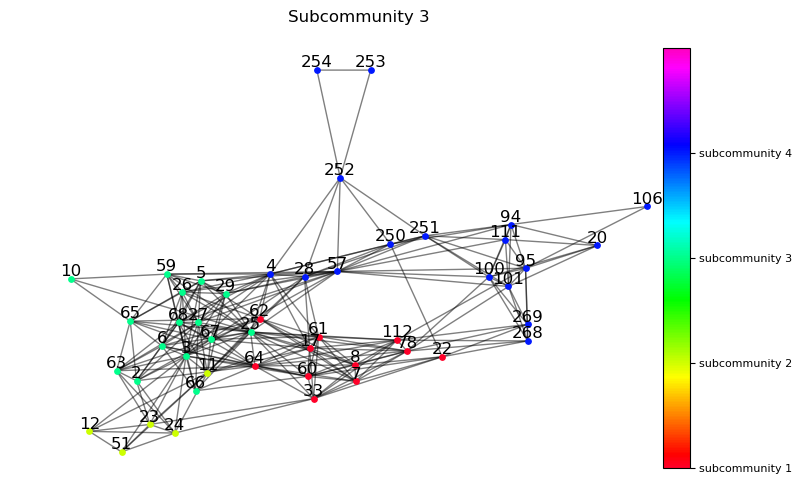

Constraining on community 4, the modularity is 0.0.
It has 6 nodes and 12 edges.
subcommunity 1
[256, 261, 247]
subcommunity 2
[72, 260, 71]


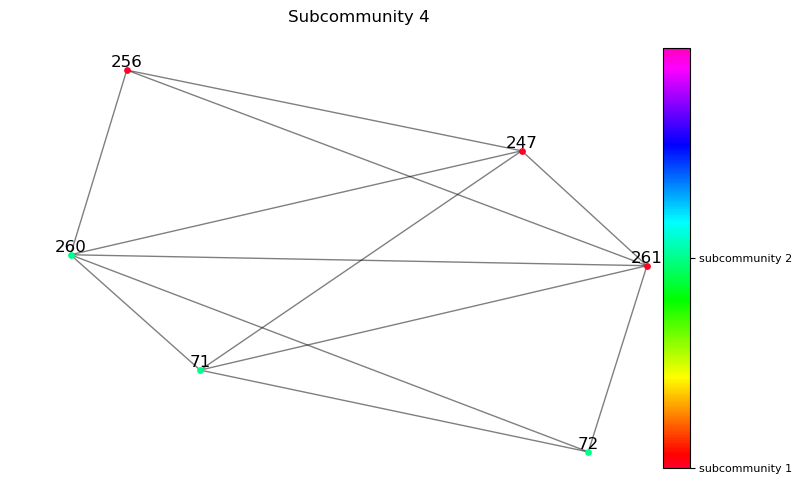

Constraining on community 5, the modularity is 0.20748108287422742.
It has 76 nodes and 976 edges.
subcommunity 1
[170, 171, 172, 267, 176, 80, 178, 82, 213, 214, 119, 118, 215, 219, 120]
subcommunity 2
[257, 258, 259, 263, 264, 266, 273, 81, 83, 84, 85, 86, 87, 88, 279, 274, 97, 102, 173, 174, 175, 113]
subcommunity 3
[69, 262, 265, 79, 275, 212, 276, 211, 281, 90, 283, 284, 93, 282, 285, 286, 99, 185, 249, 294, 103, 108, 109, 110, 177, 306, 121, 123, 124]
subcommunity 4
[98, 104, 105, 107, 77, 270, 114, 277, 280, 255]


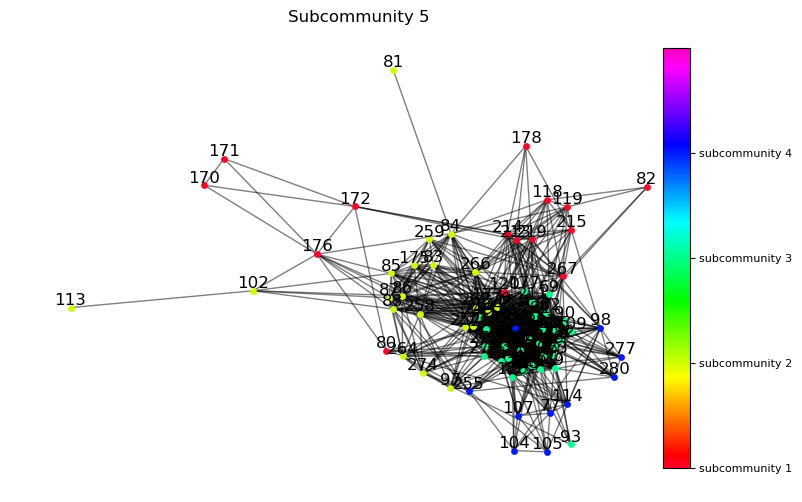

Constraining on community 6, the modularity is 0.34746329495334205.
It has 67 nodes and 533 edges.
subcommunity 1
[128, 160, 162, 159, 165, 147, 148, 149, 150, 246, 184, 125, 189, 126, 127]
subcommunity 2
[192, 193, 130, 131, 70, 199, 151, 152, 89, 227, 167, 168, 169, 243, 186, 187, 188, 191]
subcommunity 3
[137, 136, 73, 74, 139, 190]
subcommunity 4
[132, 141, 142, 144, 145, 146, 115, 179, 155]
subcommunity 5
[133, 134, 138, 75, 140, 76, 143, 153, 154, 156, 157, 158, 161, 164, 166, 234, 116, 117, 122]


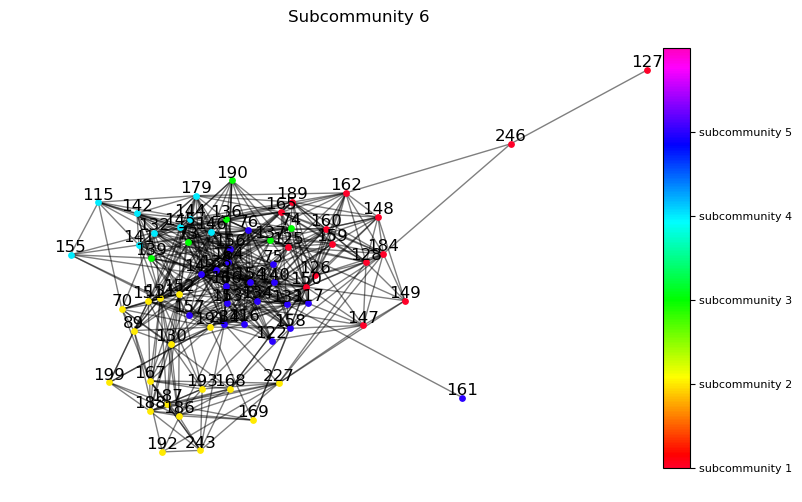

Constraining on community 7, the modularity is 0.15695473251028808.
It has 22 nodes and 135 edges.
subcommunity 1
[13, 14, 15]
subcommunity 2
[296, 297, 298, 299, 303, 272, 271, 181]
subcommunity 3
[295, 300, 301, 302, 304, 305, 307, 180, 278, 183, 182]


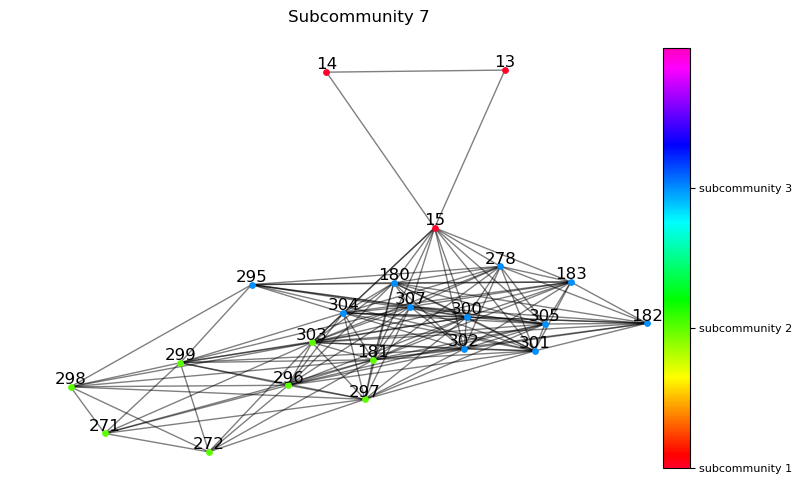

Constraining on community 8, the modularity is 0.33082194762470385.
It has 56 nodes and 401 edges.
subcommunity 1
[224, 96, 287, 203, 92, 208, 216, 217, 218, 220, 222, 223]
subcommunity 2
[195, 228, 197, 229, 198, 230, 135, 196, 235, 204, 237, 205, 241, 244]
subcommunity 3
[129, 200, 201, 202, 207, 91, 289, 290, 163, 291, 293, 292, 232, 233, 236, 238, 248]
subcommunity 4
[288, 225, 226, 194, 231, 206, 239, 240, 209, 210, 242, 245, 221]


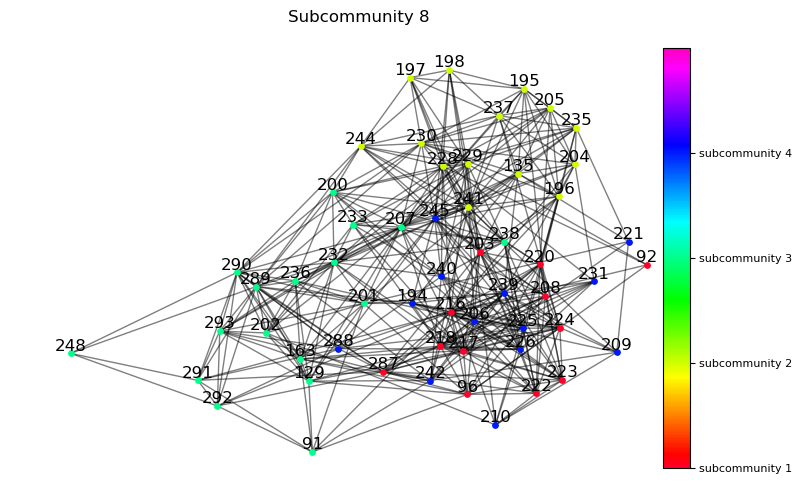

In [14]:
louvain_on_communities(G, communities)

As we can see, despite the returned modularity of the whole network is quite high $(\approx 0.636)$ looking for the maximal modularity misses relevant structures of the networks at smaller scale. This is particularly evident in the second and third subcommunities that present a sufficiently clear finer structure, as testified by their non negiglible modularity value.